In [1]:
# Mount Google Drive
# from google.colab import drive
# import os

# drive.mount('/content/gdrive')
# # Define base folder path
# base_path = '/content/gdrive/MyDrive/RGB_data_stream'
base_path = '../'

In [2]:
import os

csv_path = os.path.join(base_path,'data/3DYoga90_corrected.csv')
sequence_path = os.path.join(base_path, 'short/downloaded_log.txt')
save_path = os.path.join(base_path, 'Second_Resnet_nov6')
os.makedirs(save_path, exist_ok=True)
pose_list = ['mountain', 'half-way-lift', 'standing-forward-bend', 'downward-dog']
NUM_CLASSES = len(pose_list)
video_dir = os.path.join(base_path, 'short')
preprocessed_dir = os.path.join(base_path, 'complete_pre_processed')
os.makedirs(preprocessed_dir, exist_ok=True)
horz_aug =  os.path.join(base_path, 'horz_aug')
os.makedirs(horz_aug, exist_ok=True)

In [3]:
# Constants
FRAME_HEIGHT = 224  # VGG16 input size
FRAME_WIDTH = 224
SEQUENCE_LENGTH = 5

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms.v2 as T
import random

class VideoAugmentationPipeline:
    """Video augmentation pipeline using batch transforms from torchvision.transforms.v2"""
    def __init__(self, spatial_aug_config=None, temporal_aug_config=None):
        self.spatial_aug_config = spatial_aug_config or {
            'random_resized_crop': {'enabled': False, 'scale': (0.8, 1.0)},
            'random_horizontal_flip': {'enabled': True, 'p': 0.5},
            'color_jitter': {'enabled': True, 'brightness': 0.2, 'contrast': 0.2, 'saturation': 0.2},
            'gaussian_blur': {'enabled': True, 'p': 0.3},
            'random_rotation': {'enabled': True, 'degrees': (-10, 10)},
        }
        
        self.temporal_aug_config = temporal_aug_config or {
            'temporal_crop': {'enabled': True, 'crop_size': 0.8},
            'temporal_mask': {'enabled': True, 'n_masks': 2, 'mask_size': 0.1},
        }
        
        # Build transforms that can handle batch inputs
        self.spatial_transforms = self._build_spatial_transforms()
        
    def _build_spatial_transforms(self):
        """Build composition of spatial transforms that support batch processing"""
        transform_list = []
        
        if self.spatial_aug_config['random_resized_crop']['enabled']:
            transform_list.append(
                T.RandomResizedCrop(
                    size=(224, 224),
                    scale=self.spatial_aug_config['random_resized_crop']['scale'],
                    antialias=True
                )
            )
            
        if self.spatial_aug_config['random_horizontal_flip']['enabled']:
            transform_list.append(
                T.RandomHorizontalFlip(p=self.spatial_aug_config['random_horizontal_flip']['p'])
            )
            
        if self.spatial_aug_config['color_jitter']['enabled']:
            transform_list.append(
                T.ColorJitter(
                    brightness=self.spatial_aug_config['color_jitter']['brightness'],
                    contrast=self.spatial_aug_config['color_jitter']['contrast'],
                    saturation=self.spatial_aug_config['color_jitter']['saturation']
                )
            )
            
        if self.spatial_aug_config['gaussian_blur']['enabled']:
            transform_list.append(
                T.GaussianBlur(
                    kernel_size=(5, 5),
                    sigma=(0.1, 2.0)
                )
            )
            
        if self.spatial_aug_config['random_rotation']['enabled']:
            transform_list.append(
                T.RandomRotation(
                    degrees=self.spatial_aug_config['random_rotation']['degrees'],
                    interpolation=T.InterpolationMode.BILINEAR
                )
            )
            
        # Always normalize at the end
        transform_list.extend([
            T.ConvertImageDtype(torch.float32),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        return T.Compose(transform_list)
    
    def apply_temporal_augmentation(self, video_tensor):
        """Apply temporal augmentations to video tensor"""
        if not any(cfg['enabled'] for cfg in self.temporal_aug_config.values()):
            return video_tensor
            
        T, C, H, W = video_tensor.shape
        
        # Temporal crop
        if self.temporal_aug_config['temporal_crop']['enabled']:
            crop_size = int(T * self.temporal_aug_config['temporal_crop']['crop_size'])
            start_idx = random.randint(0, T - crop_size)
            video_tensor = video_tensor[start_idx:start_idx + crop_size]
            
        # Temporal masking
        if self.temporal_aug_config['temporal_mask']['enabled']:
            T = len(video_tensor)
            mask_size = int(T * self.temporal_aug_config['temporal_mask']['mask_size'])
            for _ in range(self.temporal_aug_config['temporal_mask']['n_masks']):
                if random.random() < 0.5:
                    start_idx = random.randint(0, T - mask_size)
                    video_tensor[start_idx:start_idx + mask_size] = 0
                    
        return video_tensor
    
    def __call__(self, video_tensor):
        """Apply transforms to entire video tensor at once"""
        # Input shape: [T, C, H, W]
        # Reshape to [T, C, H, W] -> [1, T, C, H, W] for batch processing
        video_tensor = video_tensor.unsqueeze(0)
        
        # Apply spatial transforms to entire video tensor at once
        # transforms.v2 will maintain temporal consistency automatically
        video_tensor = self.spatial_transforms(video_tensor)
        
        # Remove batch dimension
        video_tensor = video_tensor.squeeze(0)
        
        # Apply temporal augmentations
        # video_tensor = self.apply_temporal_augmentation(video_tensor)
        
        return video_tensor

In [5]:
import os
import torch
import pandas as pd
import numpy as np
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import imageio

class YogaVideoDataset(Dataset):
    def __init__(self, csv_path, sequence_path, pose_list, video_dir, preprocessed_dir,
                 spatial_aug_config=None, temporal_aug_config=None, use_augmentation=True):
        with open(sequence_path) as f:
            sequence_list = f.read().splitlines()
            sequence_list = [int(x) for x in sequence_list]
            
        self.df = pd.read_csv(csv_path)
        self.df = self.df[self.df['sequence_id'].isin(sequence_list)]
        self.df = self.df[self.df['l3_pose'].isin(pose_list)]
        
        self.pose_to_idx = {pose: idx for idx, pose in enumerate(pose_list)}
        self.length_of_dataset = len(self.df)
        
        self.video_dir = video_dir
        self.preprocessed_dir = preprocessed_dir
        self.use_augmentation = use_augmentation
        
        # Initialize augmentation pipeline
        self.augmentation_pipeline = VideoAugmentationPipeline(
            spatial_aug_config=spatial_aug_config,
            temporal_aug_config=temporal_aug_config
        )
        
        self.cache = dict()
        
    def __len__(self):
        return self.length_of_dataset
        
    def __getitem__(self, i):
        sequence_id = self.df.iloc[i]['sequence_id']
        pose = self.df.iloc[i]['l3_pose']
        label = self.pose_to_idx[pose]
        
        # Load preprocessed frames
        if sequence_id in self.cache:
            frames = self.cache[sequence_id]
        else:
            file_path = os.path.join(self.preprocessed_dir, f"{sequence_id}.pt")
            frames = torch.load(file_path, weights_only=True)
            self.cache[sequence_id] = frames
            
        # Apply augmentations during training if enabled
        if self.use_augmentation:
            frames = self.augmentation_pipeline(frames)
            
        save_path = os.path.join(horz_aug, f'{sequence_id}.pt')
        torch.save(frames, save_path)
        return frames, label

In [6]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    frames, labels = zip(*batch)

    # Pad the frames to the maximum sequence length in the batch
    frames_padded = pad_sequence(frames, batch_first=True, padding_value=0)  # Shape: [batch_size, max_seq_len, 3, 224, 224]

    labels = torch.tensor(labels)

    return frames_padded, labels

In [7]:
from tqdm import tqdm
from torch.utils.data import DataLoader

dataset = YogaVideoDataset(csv_path, sequence_path, pose_list, video_dir, preprocessed_dir)
# loader = DataLoader(
#     dataset,
#     batch_size=32,
#     shuffle=True,
#     num_workers=2,
#     pin_memory=True,
#     collate_fn=collate_fn  # Use custom collate function
# )
# train_loader_tqdm = tqdm(enumerate(loader), total=len(loader), desc="Processing Clips")
# for batch_idx, (inputs, labels) in train_loader_tqdm:
#           print("DONE")
for i, data in enumerate(dataset):
  print('Data', i)

Data 0
Data 1
Data 2
Data 3
Data 4
Data 5
Data 6
Data 7
Data 8
Data 9
Data 10
Data 11
Data 12
Data 13
Data 14
Data 15
Data 16
Data 17
Data 18
Data 19
Data 20
Data 21
Data 22
Data 23
Data 24
Data 25
Data 26
Data 27
Data 28
Data 29
Data 30
Data 31
Data 32
Data 33


FileNotFoundError: [Errno 2] No such file or directory: '../complete_pre_processed\\1036.pt'

In [8]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
denormalize = transforms.Normalize(
    mean=[-m/s for m, s in zip(imagenet_mean, imagenet_std)],
    std=[1/s for s in imagenet_std]
)

C:\Users\aagab\AppData\Local\Temp\ipykernel_17520\373403625.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_frames = torch.load(original_path)
C:\Users\aagab\A

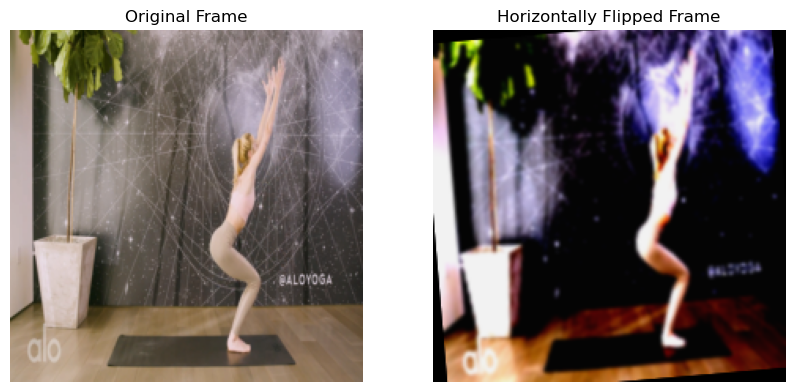

In [9]:
import torch
import matplotlib.pyplot as plt
import os
from torchvision.transforms import ToPILImage

def plot_sample(preprocessed_dir, aug_dir, sample_number):
    # Define file paths for the original and augmented sequences
    original_path = os.path.join(preprocessed_dir, f"{sample_number}.pt")
    augmented_path = os.path.join(aug_dir, f"{sample_number}.pt")

    # Load the tensors
    if not os.path.exists(original_path) or not os.path.exists(augmented_path):
        print(f"Sample {sample_number} not found in either {preprocessed_dir} or {aug_dir}")
        return

    original_frames = torch.load(original_path)
    augmented_frames = torch.load(augmented_path)

    # Select the first frame (or any frame you prefer to visualize)
    frame_idx = 0
    original_frame = original_frames[frame_idx]
    augmented_frame = augmented_frames[frame_idx]

    original_frame = denormalize(original_frame)
    augmented_frame = denormalize(augmented_frame)

    # Convert tensors to PIL images for visualization
    to_pil = ToPILImage()
    original_image = to_pil(original_frame)
    augmented_image = to_pil(augmented_frame)

    # Plot both images side-by-side
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(original_image)
    ax[0].set_title("Original Frame")
    ax[0].axis("off")

    ax[1].imshow(augmented_image)
    ax[1].set_title("Horizontally Flipped Frame")
    ax[1].axis("off")

    tsave = os.path.join(aug_dir, 'aug_result.png')
    plt.savefig(tsave)
    plt.show()

# Example usage:
plot_sample(preprocessed_dir, horz_aug, 1000)


C:\Users\aagab\AppData\Local\Temp\ipykernel_17520\2845221297.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_frames = torch.load(original_path)
C:\Users\aagab\

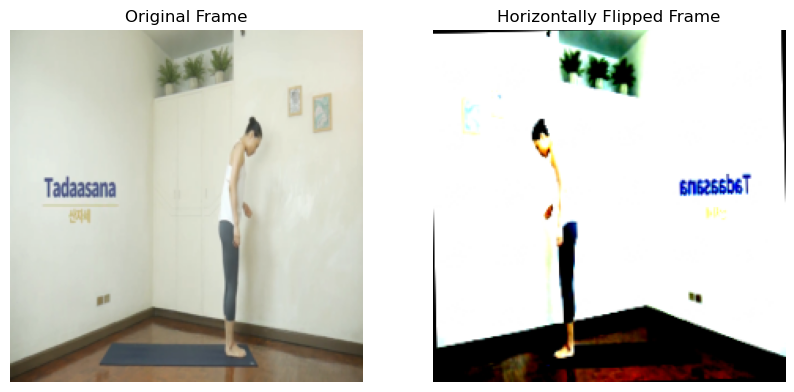

In [10]:
def plot_sample(preprocessed_dir, aug_dir, sample_number):
    # Define file paths for the original and augmented sequences
    original_path = os.path.join(preprocessed_dir, f"{sample_number}.pt")
    augmented_path = os.path.join(aug_dir, f"{sample_number}.pt")

    # Load the tensors
    if not os.path.exists(original_path) or not os.path.exists(augmented_path):
        print(f"Sample {sample_number} not found in either {preprocessed_dir} or {aug_dir}")
        return

    original_frames = torch.load(original_path)
    augmented_frames = torch.load(augmented_path)

    # Select the first frame (or any frame you prefer to visualize)
    frame_idx = 10
    original_frame = original_frames[frame_idx]
    augmented_frame = augmented_frames[frame_idx]

    original_frame = denormalize(original_frame)
    augmented_frame = denormalize(augmented_frame)

    # Convert tensors to PIL images for visualization
    to_pil = ToPILImage()
    original_image = to_pil(original_frame)
    augmented_image = to_pil(augmented_frame)

    # Plot both images side-by-side
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(original_image)
    ax[0].set_title("Original Frame")
    ax[0].axis("off")

    ax[1].imshow(augmented_image)
    ax[1].set_title("Horizontally Flipped Frame")
    ax[1].axis("off")

    tsave = os.path.join(aug_dir, 'aug_result.png')
    plt.savefig(tsave)
    plt.show()

# Example usage:
plot_sample(preprocessed_dir, horz_aug, 1010)